## 1622 Assignment 1

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cplex


### Define four portfolio re-balancing strategies

In [2]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    # Value of the portfolio
    portfolio_value = np.dot(cur_prices,x_init) + cash_init 
    # Value of each asset
    asset_value = np.ones((20)) * portfolio_value / 20 
    # Optimal shares of each asset
    x_optimal = np.floor(asset_value / cur_prices) 
    # 0.5% of the value get from selling or buying
    transaction_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005 
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - transaction_cost 
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # initialize the CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)   
    # No linear part of objective function
    c = np.zeros((20)) 
    # Define bounds on variables (lower bounds default as zeros)
    ub = np.ones((20))   
    # Define constraint matrix A
    # Sum of weights: w1+w2+w3+....+w20 = 1
    # No shorting: wi >= 0
    A = []
    n = 20
    for i in range(n):
        A.append([[0,1],[1,0]])    
    # Add constraints to CPLEX model
    # Sum of weights equal to one and no shorting allowed
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG') 
    names = ['x_%s'% i for i in range(1,21)]
    cpx.variables.add(obj=c,ub=ub,columns=A,names=names)    
    # Define and add quadratic part of objective function
    qmat = [[list(range(n)),list(2*Q[k,:])] for k in range(n)] # Q covariance matrix
    cpx.objective.set_quadratic(qmat)    
    # No output from CPLEX
    cpx.set_results_stream(None)
    cpx.set_log_stream(None)
    cpx.set_warning_stream(None)
    cpx.set_error_stream(None)
    cpx.solve()    
    # Store the solutions into weights
    weights = np.array(cpx.solution.get_values())
    portfolio_value = np.dot(cur_prices,x_init) + cash_init # Value of the portfolio
    asset_value = weights * portfolio_value # Value of each asset
    x_optimal = np.floor(asset_value / cur_prices) # Optimal shares of each asset
    transaction_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005 # 0.5% of the value of net shares
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - transaction_cost 
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    n = 21 # 21 variables
    r_rf = 0.025 # risk-free rate
    daily_rf = 0.025 / 252 # daily risk-free rate
    # Matrix Q is 21x21 dimension
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    new_row = np.zeros((21))
    Q2 = np.vstack([Q1,new_row]) #add new column and new row for a new variable k
    diff = mu-daily_rf * np.ones(20) # difference between expected return and rf rate
    # Define constraint matrix A
    # Summation of (mu-rf)yi = 1
    # Summation of yi - k = 0
    A = []
    for i in range(n-1):
        A.append([[0,1],[diff[i],1.0]])
    A.append([[0,1],[0,-1.0]])
    
    # initialize the CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    # Add objective function, bounds on variables and constraints to CPLEX model
    # Sum of (mu-daily_rf)*yi equal to one and Sum of weights equal to one
    c = np.zeros((n))
    ub = [np.inf]*n
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE')
    names = ['y_%s'% i for i in range(1,n+1)]
    cpx.variables.add(obj=c,ub=ub,columns=A,names=names)
    qmat = [[list(range(n)),list(2*Q2[k,:])] for k in range(n)] # Q variance-covariance matrix
    cpx.objective.set_quadratic(qmat)
    
    # No output from CPLEX
    cpx.set_results_stream(None)
    cpx.set_log_stream(None)
    cpx.set_warning_stream(None)
    cpx.set_error_stream(None)
    cpx.solve()
    result = np.array(cpx.solution.get_values())
    weights = result[0:20]/result[20] # wi = yi/k
    
    portfolio_value = np.dot(cur_prices,x_init) + cash_init # Value of the portfolio
    asset_value = weights * portfolio_value # Value of each asset
    x_optimal = np.floor(asset_value / cur_prices) # Optimal shares of each asset
    transaction_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005 # 0.5% of the value get from selling or buying
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - transaction_cost 
    return x_optimal, cash_optimal


In [3]:
def strat_buy_and_hold_equally(x_init, cash_init, mu, Q, cur_prices):
    
    portfolio_value = np.dot(cur_prices,x_init) + cash_init
    # wi = (initial portfolio / 20) / cur_prices(i)
    x_optimal = [486,5837,493,46,2205,818,1360,980,924,478,1895,1174,1898,1096,2472,898,230,30,1155,1113]
    transaction_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_value - np.dot(cur_prices,x_optimal) - transaction_cost       
    return np.array(x_optimal), cash_optimal

### Produce the following output for the 12 periods (years 2019 and 2020)

In [4]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv('/Users/angelahsu/Desktop/Daily_closing_prices.csv')

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2018 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2018
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2019-2020 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe','strat_buy_and_hold_equally']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio','Equally Weighted Always']
#N_strat = 1
N_strat = len(strategy_functions)
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_buy_and_hold_equally]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 19:
        cur_year  = 19 + math.floor(period/7)
    else:
        cur_year  = 2019 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy in range(N_strat):
        
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        if cash[strategy, period-1] < 0:
            # Check how much value the current portfolio is
            portfolio_value = np.dot(cur_prices,curr_positions) + curr_cash
            
            # The portion for each stock 
            portion = x[strategy, period-1]/sum(x[strategy, period-1])
            
            # The cash that need to save for each stock
            save_cash = abs(cash[strategy, period-1])*portion

            # The shares that need to sell for each stock, which is rounded up to integers
            shares = np.ceil(save_cash/cur_prices)
            
            # The new optimal shares for each stock is the difference between original shares and the shares 
            # that need to be sold
            x[strategy, period-1] = x[strategy, period-1] - shares
            
            # Transaction cost is 0.5% of the value of net shares for each stock
            new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            
            # The new optimal cash is the remain by minus original portfolio value 
            # by current portfolio value and transaction cost
            cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
        
        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000070.06


Period 1: start date 01/02/2019, end date 02/28/2019
  Strategy "Buy and Hold", value begin = $ 1000070.06, value end = $ 1121179.83
  Strategy "Equally Weighted Portfolio", value begin = $ 991124.38, value end = $ 1097031.81
  Strategy "Mininum Variance Portfolio", value begin = $ 991702.28, value end = $ 1057440.44
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990119.39, value end = $ 1016524.41
  Strategy "Equally Weighted Always", value begin = $ 991578.79, value end = $ 1087997.58

Period 2: start date 03/01/2019, end date 04/30/2019
  Strategy "Buy and Hold", value begin = $ 1126131.27, value end = $ 1075001.89
  Strategy "Equally Weighted Portfolio", value begin = $ 1103260.47, value end = $ 1188731.33
  Strategy "Mininum Variance Portfolio", value begin = $ 1055378.90, value end = $ 1107930.67
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1007118.10, value end = $ 1076636.20
  Strategy "Equally Weighted Alw

### Plot a chart that illustrates the daily value of portfolio

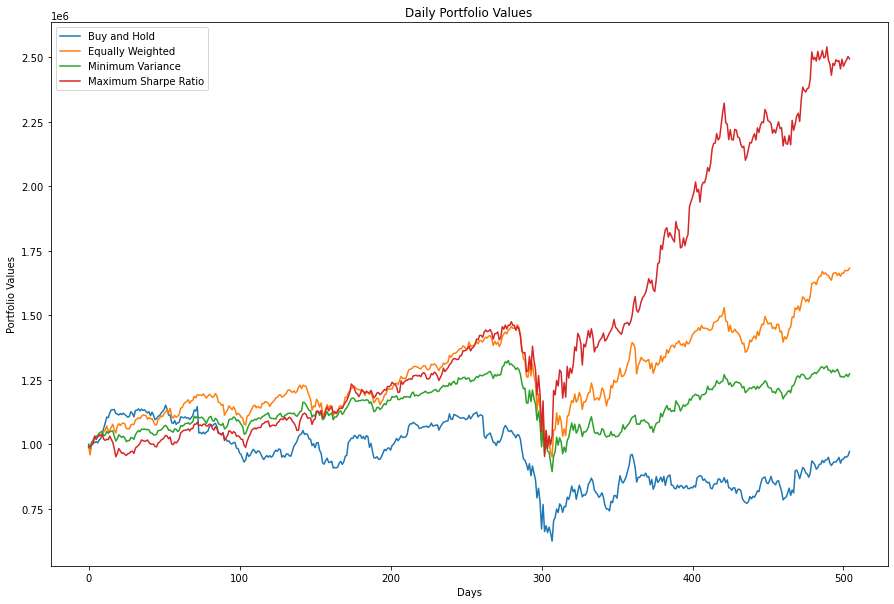

In [5]:
plt.figure(figsize=(15,10))
plt.plot(portf_value[0],label='Buy and Hold')
plt.plot(portf_value[1],label='Equally Weighted')
plt.plot(portf_value[2],label='Minimum Variance')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio')
plt.legend()
plt.title('Daily Portfolio Values')
plt.xlabel('Days')
plt.ylabel('Portfolio Values')
plt.show()

### Plot dynamic changes in "Minimum variance" portfolio allocations

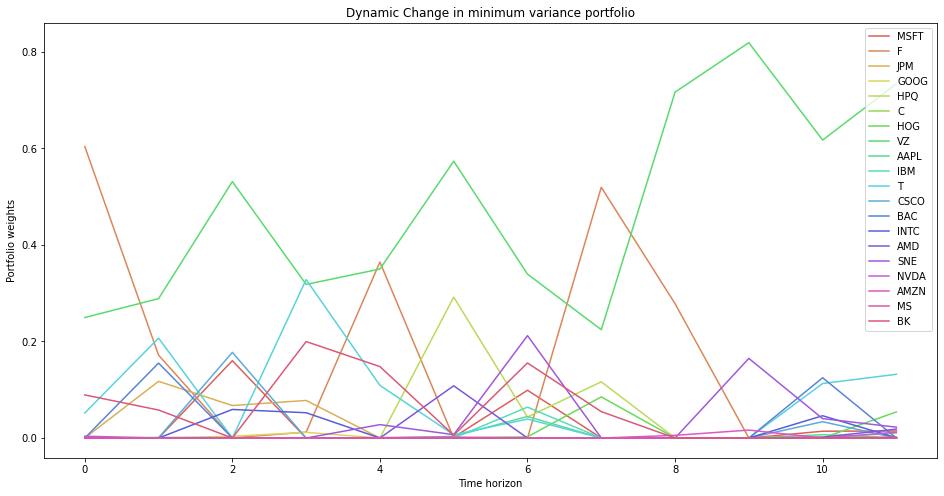

In [6]:
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 20))

# extract symbols of stocks
symbols = df.columns[1:]

# store list of weights
weights1 = []

# compute strat_min_variance
x[2, period-1], cash[2, period-1] = fh_array[2](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    weight1 = x[2, period-1]/sum(x[2, period-1])
    weights1.append(weight1)
df1 = pd.DataFrame(np.array(weights1),columns=symbols)
df1.plot(kind='line',figsize=(16,8))

plt.title('Dynamic Change in minimum variance portfolio')
plt.xlabel('Time horizon')
plt.ylabel('Portfolio weights')
plt.legend(symbols,loc='upper right')
plt.show()

### Plot dynamic changes in "Maximum Sharpe ratio" portfolio allocations

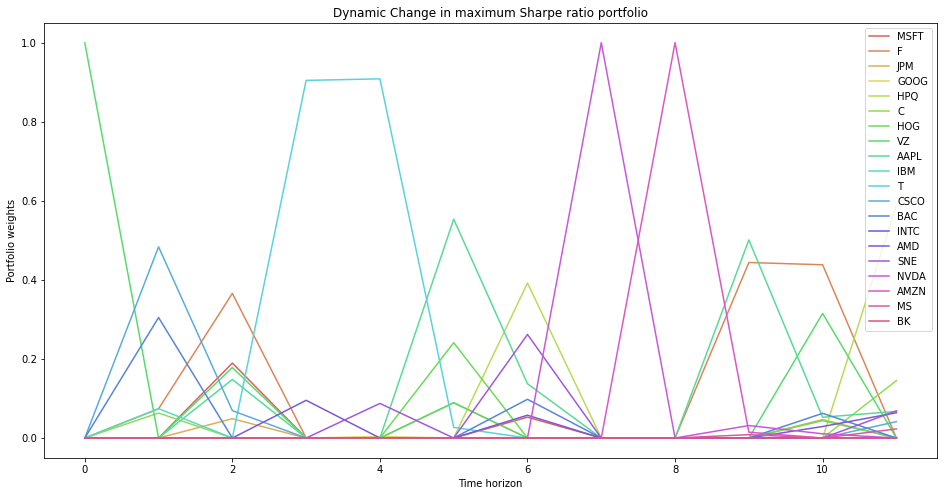

In [7]:
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 20))

# extract symbols of stocks
symbols = df.columns[1:]

#store list of weights
weights2 = []

# compute strat_max_Sharpe
x[3, period-1], cash[3, period-1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)

for period in range(1, N_periods+1):
    weight2 = x[3, period-1]/sum(x[3, period-1])
    weights2.append(weight2)
df2 = pd.DataFrame(np.array(weights2),columns=symbols)
df2.plot(kind='line',figsize=(16,8))

plt.title('Dynamic Change in maximum Sharpe ratio portfolio')
plt.xlabel('Time horizon')
plt.ylabel('Portfolio weights')
plt.legend(symbols,loc='upper right')
plt.show()